# Loading Data

## Reading Raw Data

In [1]:
!pip install antropy
!pip install mne

import numpy as np
import mne
import os
import gdown
import zipfile
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
import matplotlib.pyplot as plt

import warnings

# Ignorar advertencias de MNE para limpiar la salida
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 47.3 MB/s eta 0:00:00


In [32]:
data = "/content/chb01_04.edf"
raw = mne.io.read_raw_edf(data, preload = True)

Extracting EDF parameters from /content/chb01_04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


In [31]:
data_2 = "/content/chb01_05.edf"
raw_2 = mne.io.read_raw_edf(data_2, preload = True)

Extracting EDF parameters from /content/chb01_05.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


In [33]:
print(raw)
print(raw.info)

<RawEDF | chb01_04.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 14:43:12 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>


In [34]:
print(raw_2)
print(raw_2.info)

<RawEDF | chb01_05.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 15:43:19 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>


Important information of the EEG data: 23 channels with 921600 time points; sampling rate is 256.0 Hz; data length is 3600.0 s; data size is about 161.7 MB.\
\
The name of channels are FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3,P3-O1, ..., etc.\
\
0.0 Hz High-pass filtering and 128.0 Hz low-pass filtering

# Visualizing Raw Data

## Plot raw data waveforms

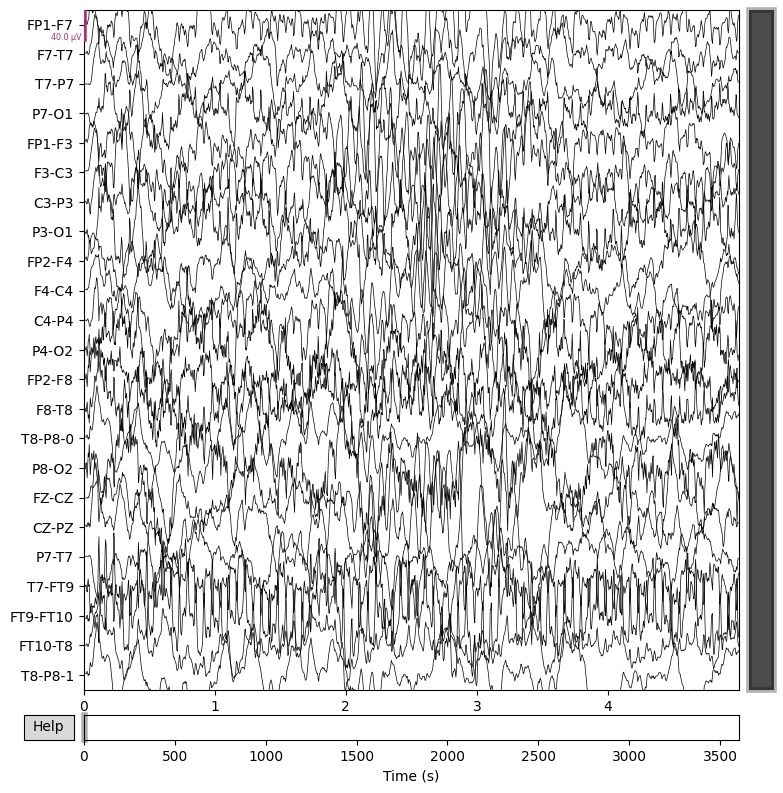

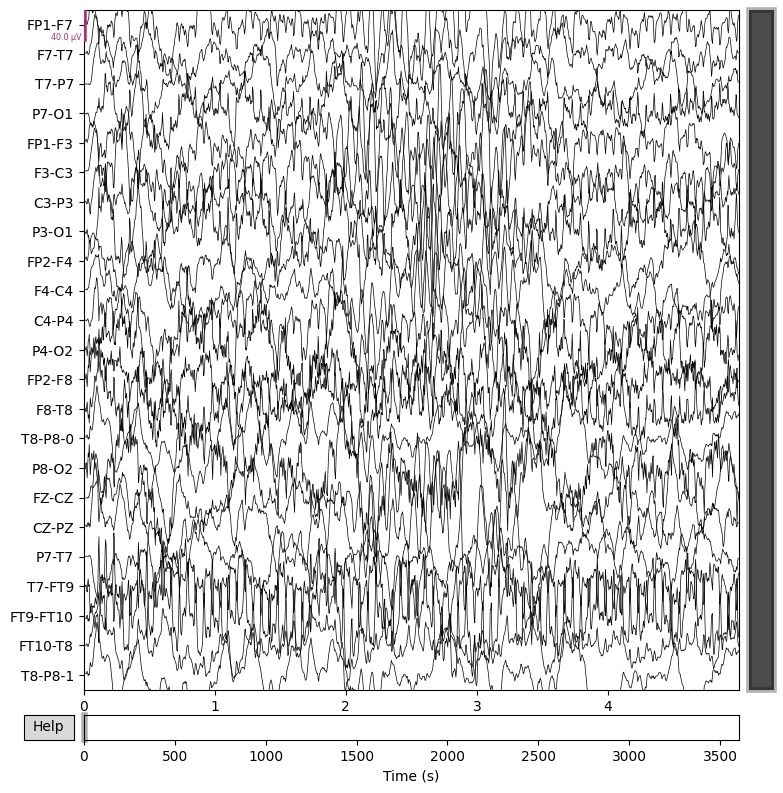

In [35]:
raw.plot(duration = 5, n_channels = 23, clipping = None)

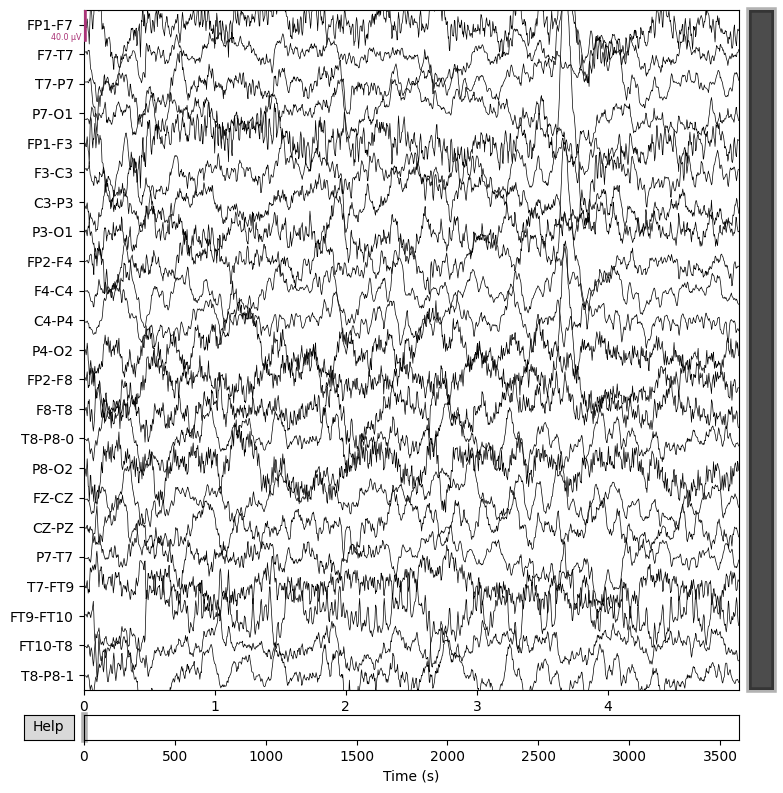

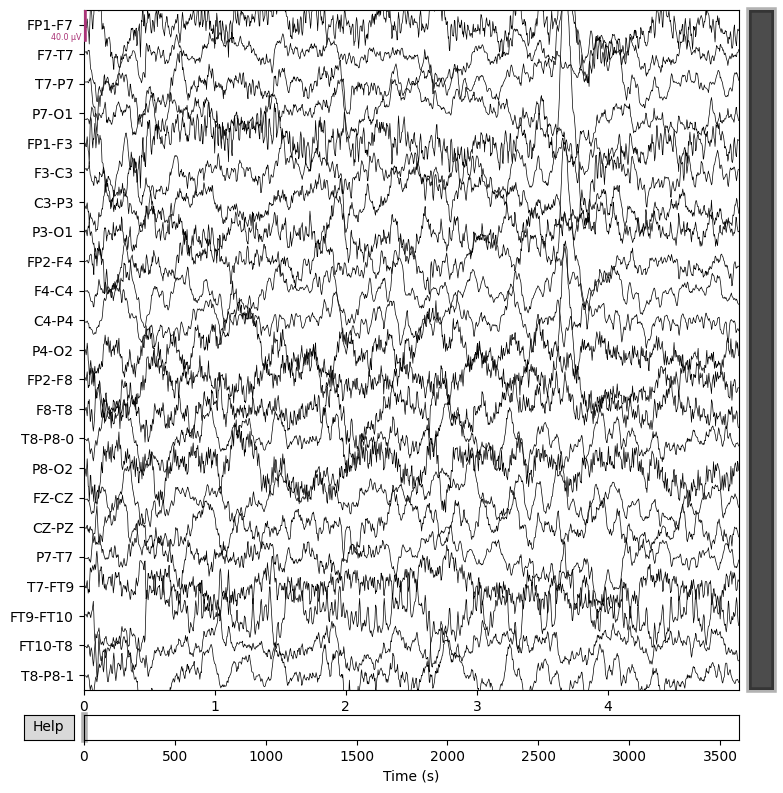

In [36]:
raw_2.plot(duration = 5, n_channels = 23, clipping = None)

## Plot power spectral density across channels

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


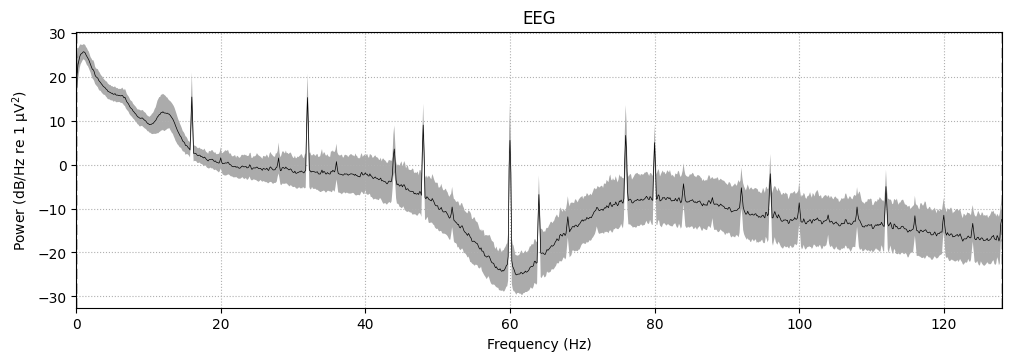

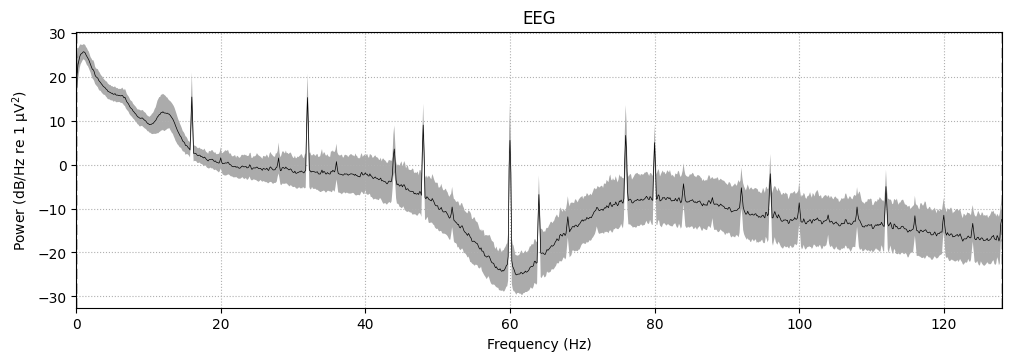

In [7]:
raw.plot_psd(average = True)

# Filtering Data

Here first use the trap filter to remove utility frequency.
Different countries and areas may have different utility frequencies. In U.S.A is 60 Hz

In [8]:
raw = raw.notch_filter(freqs = (60))

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


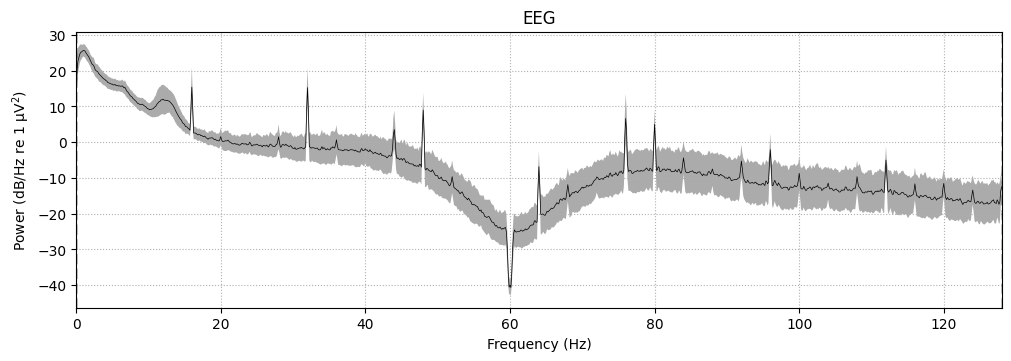

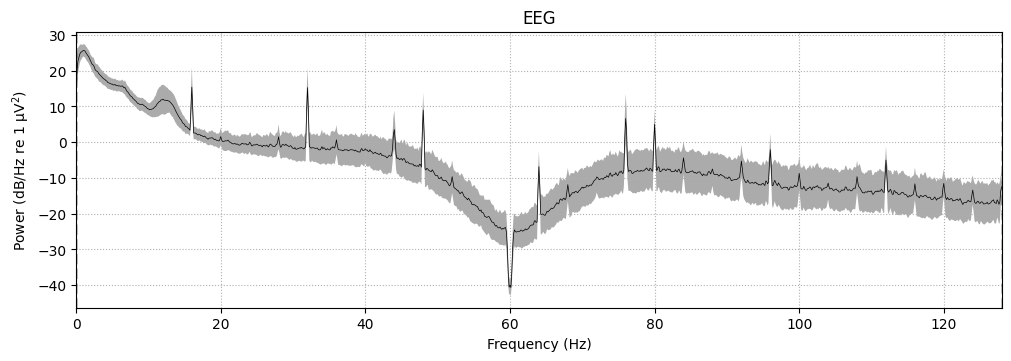

In [9]:
raw.plot_psd(average = True)

## High/Low-Pass Filtering

High-pass filtering is used to eliminate voltage drift, and low-pass filtering is used to eliminate high frequency noises.

In [10]:
raw = raw.filter(l_freq = 0.5, h_freq = 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


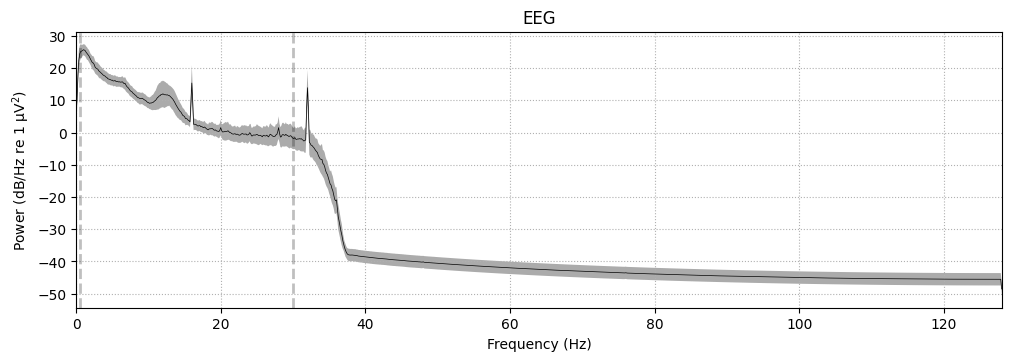

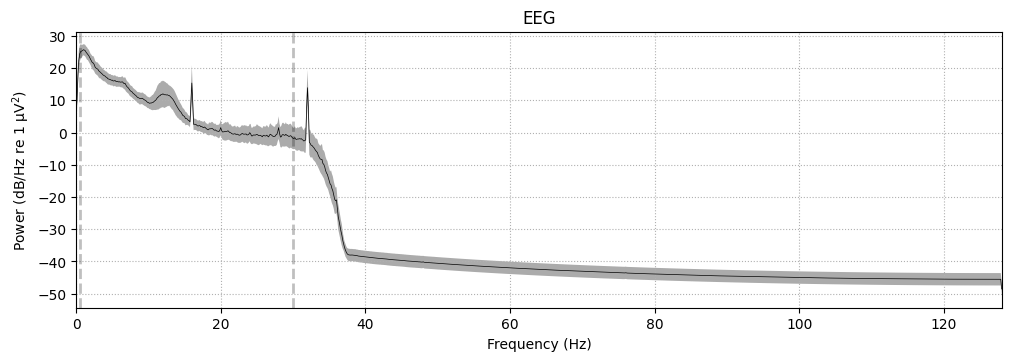

In [11]:
raw.plot_psd(average = True)

In [12]:
annotations = {
    'chb01_03.edf': [(2996, 3036)],
    'chb01_04.edf': [(1467, 1494)],
    'chb01_15.edf': [(1732, 1772)],
    'chb01_16.edf': [(1015, 1066)],
    'chb01_18.edf': [(1720, 1810)],
    'chb01_21.edf': [(327, 420)],
    'chb01_26.edf': [(1862, 1963)],
}

In [13]:
def add_annotations(raw, file, annotations):
  seizure_time = annotations.get(file, [])
  print(seizure_time)

  if len(seizure_time) > 0:
    onsets = []
    durations = []
    descriptions = []

    for start, end in seizure_time:
      onsets.append(start)
      durations.append(end - start)
      descriptions.append('BAD')

      insiders = mne.Annotations(
          onset = onsets,
          duration = durations,
          description = descriptions
      )
      print(insiders)

      raw.set_annotations(insiders)
      print(raw)

    return raw

In [14]:
raw = add_annotations(raw, 'chb01_04.edf', annotations)

[(1467, 1494)]
<Annotations | 1 segment: BAD (1)>
<RawEDF | chb01_04.edf, 23 x 888832 (3472.0 s), ~156.0 MiB, data loaded>


In [15]:
print(raw.annotations)

<Annotations | 1 segment: BAD (1)>


In [16]:
print(raw.annotations.description)

['BAD']


In [17]:
print(raw.annotations.onset)

[1467.]


In [18]:
events, event_id = mne.events_from_annotations(raw, regexp = None)

Used Annotations descriptions: [np.str_('BAD')]


In [19]:
print(events, event_id)

[[375552      0      1]] {np.str_('BAD'): 1}


## Segmentating Data

In [20]:
epochs = mne.Epochs(raw,
                    events,
                    event_id,
                    tmin = -1,
                    tmax = 2,
                    baseline = (-0.5, 0),
                    preload = True,
                    reject_by_annotation = False)

Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 769 original time points ...
0 bad epochs dropped


In [21]:
print(epochs)

<Epochs | 1 events (all good), -1 – 2 s (baseline -0.5 – 0 s), ~160 KiB, data loaded,
 np.str_('BAD'): 1>


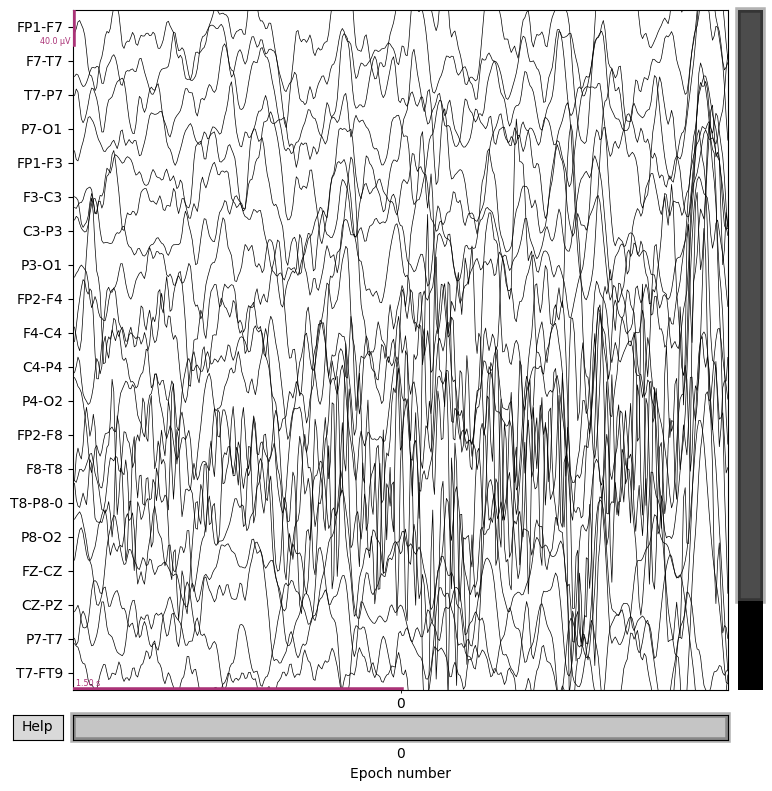

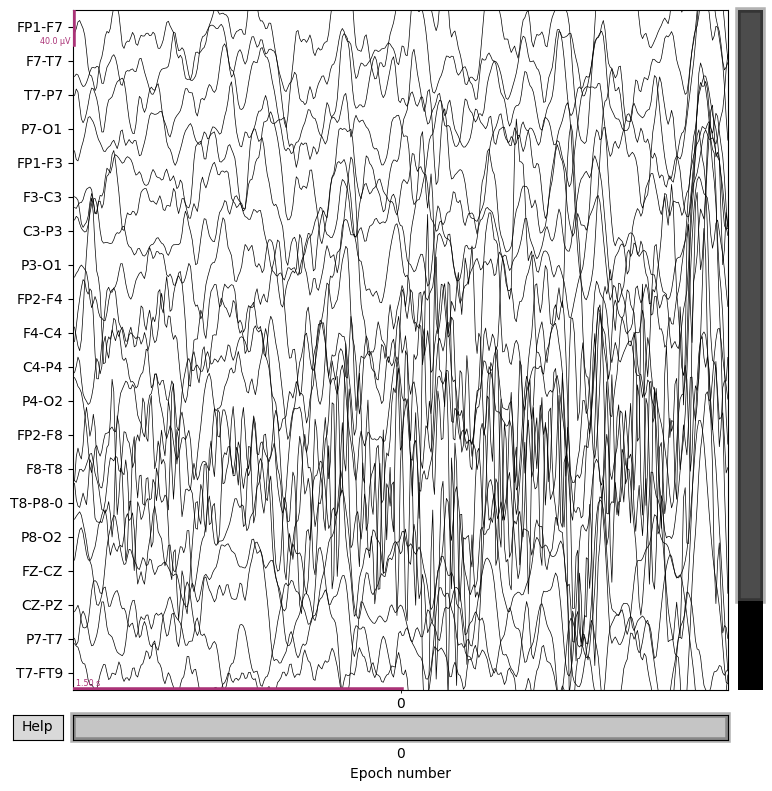

In [22]:
epochs.plot()

## Plot the power spectrum

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


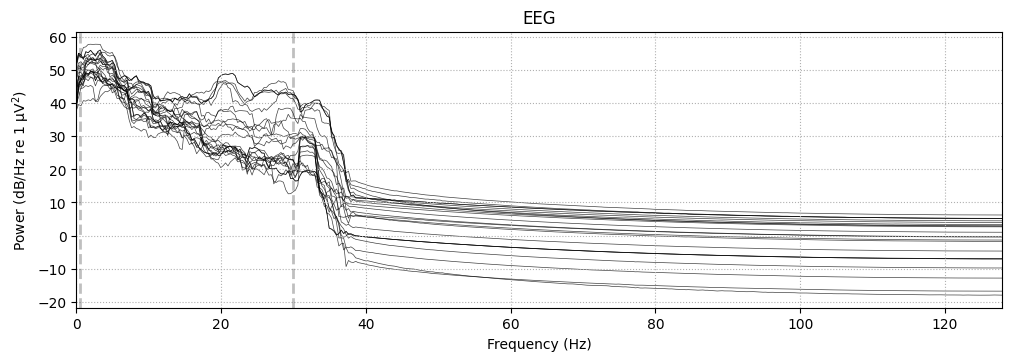

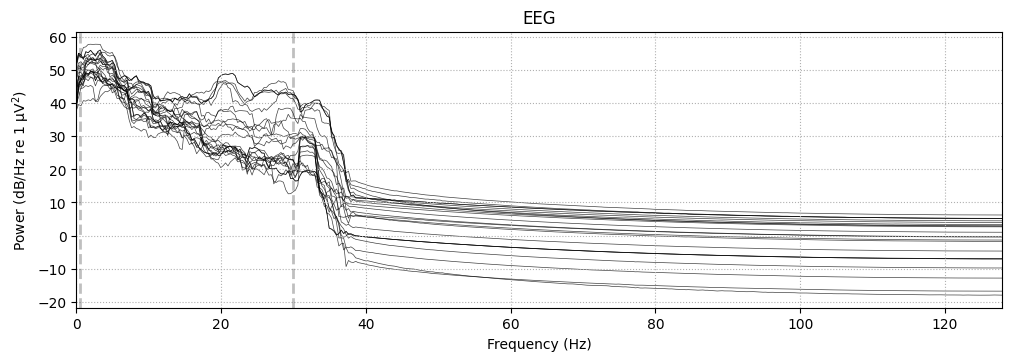

In [23]:
epochs.compute_psd().plot()

In [24]:
# Set some parameters for time-frequency analysis
# The frequency band is selected from 4 to 30 Hz

freqs = np.logspace(*np.log10([4, 30]), num=10)
n_cycles = freqs / 2.
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [25]:
root = "/Users/metamorphosus/.../chbmit/1.0.0/"
output_dir = "Datos_CNN_Hibridos"

In [26]:
# Selected patients from the CHB-MIT dataset (Assali et al., 2023)
channels_pacients = {
    'chb01': ['FP1-F7', 'F3-C3'],
    'chb02': ['F7-T7', 'T7-P7'],
    'chb03': ['T7-P7', 'P7-O1'],
    'chb04': ['P7-O1', 'P3-O1'],
    'chb06': ['F7-T7', 'T7-P7'],
    'chb07': ['F3-C3', 'F8-T8']
}

In [27]:
# The distribution of energy across frequency domain provides a more
# robust measure for revealing the preictal state.
def relative_power_spectral_density(data, s_freq):
  spectral_bands = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 50) ]

In [28]:
def extraer_features_hibridas(data, sfreq=256):
    """
    Genera un vector único combinando Assali (2023) y Tsiouris (2018).
    Input: data (n_canales, n_puntos)
    Output: Lista de números (features)
    """
    features = []

    # --- BLOQUE 1: Dominio de Frecuencia (Paper Assali) ---
    # RPSD (Delta, Theta, Alpha, Beta, Gamma)
    bandas = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 45)]
    psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq, fmin=0.5, fmax=45, verbose=False)
    total_power = np.sum(psd, axis=1, keepdims=True)

    for fmin, fmax in bandas:
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_power = np.sum(psd[:, idx], axis=1)
        # Promedio entre canales para reducir dimensiones
        rpsd = np.mean(band_power / total_power)
        features.append(rpsd)

    # --- BLOQUE 2: Complejidad (Paper Assali) ---
    # Sample Entropy (Usamos el primer canal para velocidad)
    try:
        se = ant.sample_entropy(data[0], order=2, metric='chebyshev')
        features.append(se)
    except:
        features.append(0)

    # --- BLOQUE 3: Estadística Temporal (Paper Tsiouris) ---
    # Extraemos media, varianza, skewness, kurtosis de cada canal
    for canal in data:
        features.extend([np.mean(canal), np.var(canal), skew(canal), kurtosis(canal)])

    # --- BLOQUE 4: Conectividad (Paper Tsiouris - Simplificado) ---
    # Correlación cruzada entre los dos canales (Sustituye al SI)
    if data.shape[0] >= 2:
        corr = np.corrcoef(data[0], data[1])[0, 1]
        features.append(corr)
    else:
        features.append(0)

    return np.array(features)

# ==========================================
# PROCESAMIENTO
# ==========================================
def parsear_summary(summary_path):
    """
    Lee el archivo .txt y devuelve un diccionario con los tiempos de crisis.
    Estructura: {'chb01_03.edf': [(inicio1, fin1), (inicio2, fin2)], ...}
    """
    info_crisis = {}
    current_file = None

    with open(summary_path, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        line = line.strip()

        # Detectar nombre de archivo
        if "File Name" in line:
            current_file = line.split(": ")[1]
            info_crisis[current_file] = [] # Inicializamos lista de crisis

        # Detectar inicio de crisis
        if "Seizure Start Time" in line:
            start = int(re.search(r'\d+', line).group())
            # Buscamos el final en la siguiente línea o la subsiguiente
            end_line = lines[i+1].strip()
            end = int(re.search(r'\d+', end_line).group())

            info_crisis[current_file].append((start, end))

    return info_crisis

# ==========================================
# FUNCIÓN 2: EL PROCESADOR
# ==========================================
def procesar_edf(ruta_edf, crisis_list, sujeto):
    try:
        # 1. Cargar archivo (Lazy loading)
        raw = mne.io.read_raw_edf(ruta_edf, preload=True, verbose=False)

        # 2. Selección de Canales (Importante para CNN)
        if SELECTED_CHANNELS:
            try:
                raw.pick_channels(SELECTED_CHANNELS)
            except ValueError:
                print(f"⚠️ Canales no encontrados en {ruta_edf}. Usando todos.")

        # 3. Filtrado
        raw.filter(l_freq=1.0, h_freq=50.0, verbose=False)

        # 4. Procesar CRISIS (Clase 1)
        for idx, (inicio, fin) in enumerate(crisis_list):
            # Recortar la crisis
            raw_crop = raw.copy().crop(tmin=inicio, tmax=fin)

            # Segmentar en ventanas de 2 segundos (Epochs)
            events = mne.make_fixed_length_events(raw_crop, duration=2.0)
            epochs = mne.Epochs(raw_crop, events, tmin=0, tmax=2.0, baseline=None, verbose=False)

            # --- TRANSFORMACIÓN A TIEMPO-FRECUENCIA (IMAGEN 3D) ---
            # Esto genera matriz (n_epochs, n_canales, n_freqs, n_tiempos)
            power = mne.time_frequency.tfr_morlet(epochs, freqs=FREQS, n_cycles=N_CYCLES,
                                                  return_itc=False, average=False)

            # Guardar cada ventanita
            for i in range(len(power.data)):
                data = power.data[i] # Shape: (Canales, Freqs, Tiempo)
                save_path = os.path.join(OUTPUT_DIR, "Crisis", f"{sujeto}_sz_{idx}_{i}.npy")
                np.save(save_path, data)

        # 5. Procesar NORMAL (Clase 0)
        # (Lógica simplificada: Tomamos datos lejanos a la crisis)
        # Aquí podrías agregar lógica para cortar solo secciones sin crisis
        # Por ahora, para ahorrar espacio en el chat, asume que si no hay crisis en lista,
        # toma un pedazo del principio.
        if not crisis_list:
             # Tomar solo los primeros 10 minutos como ejemplo normal
             raw_normal = raw.copy().crop(tmin=0, tmax=600)
             events = mne.make_fixed_length_events(raw_normal, duration=2.0)
             epochs = mne.Epochs(raw_normal, events, tmin=0, tmax=2.0, baseline=None, verbose=False)
             power = mne.time_frequency.tfr_morlet(epochs, freqs=FREQS, n_cycles=N_CYCLES,
                                                  return_itc=False, average=False)
             # Guardamos solo algunas muestras para balancear
             for i in range(min(len(power.data), 20)):
                data = power.data[i]
                save_path = os.path.join(OUTPUT_DIR, "Normal", f"{sujeto}_norm_{i}.npy")
                np.save(save_path, data)

        # Limpiar memoria RAM agresivamente
        del raw, power, epochs

    except Exception as e:
        print(f"❌ Error en {ruta_edf}: {e}")

# ==========================================
# BUCLE PRINCIPAL (MAIN LOOP)
# ==========================================
if __name__ == "__main__":
    # Crear carpetas
    os.makedirs(os.path.join(OUTPUT_DIR, "Crisis"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "Normal"), exist_ok=True)

    # 1. Buscar y leer el summary.txt (Asumimos que está en ROOT_DIR)
    # Tienes que buscar dónde está tu archivo chb01-summary.txt
    # Aquí un ejemplo iterando carpetas de pacientes
    pacientes = [f"chb{i:02d}" for i in range(1, 24)] # chb01 a chb23

    for paciente in pacientes:
        folder_path = os.path.join(ROOT_DIR, paciente)
        summary_file = os.path.join(folder_path, f"{paciente}-summary.txt")

        if os.path.exists(summary_file):
            print(f"📖 Leyendo sumario de {paciente}...")
            mapa_crisis = parsear_summary(summary_file)

            # Procesar archivos de este paciente
            for archivo_nombre, crisis in mapa_crisis.items():
                ruta_completa = os.path.join(folder_path, archivo_nombre)
                if os.path.exists(ruta_completa):
                    print(f"Procesando {archivo_nombre} | Crisis detectadas: {len(crisis)}")
                    procesar_edf(ruta_completa, crisis, paciente)
        else:
            print(f"Salatando {paciente}, no encontré summary.txt")

NameError: name 'OUTPUT_DIR' is not defined